In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [5]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np

X, l = DensityDatasets.aggregation.standardized_data_cached

In [14]:
from src.Cluster.DPC.cluster import DensityPeakCluster

l_dpc = DensityPeakCluster(anormal=False).fit(X).labels_

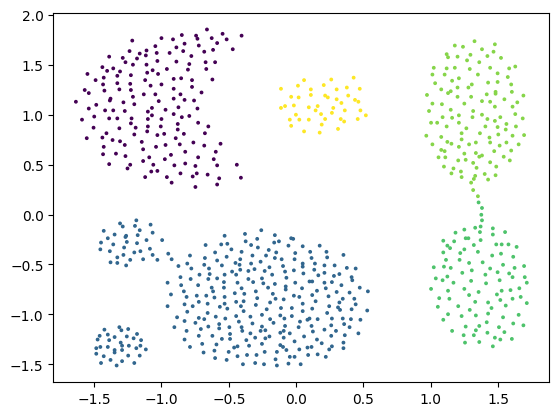

In [15]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_dpc)
plt.show()

In [13]:
from src.Evaluation import disco_score

disco_score(X, l), disco_score(X, l_dpc)

(0.3056510576364597, 0.5138099180630531)